In [1]:
# General Dependencies
import os
import numpy as np


# Denoising dependencies
from trefide.pmd import batch_decompose,\
                        batch_recompose,\
                        overlapping_batch_decompose,\
                        overlapping_batch_recompose,\
                        determine_thresholds


from trefide.reformat import overlapping_component_reformat

# Plotting & Video Rendering Dependencies
import funimag

import matplotlib.pyplot as plt
from trefide.plot import pixelwise_ranks
from trefide.video import play_cv2

# Set Demo Dataset Location
ext = os.path.join("..", "example_movies")
filename = os.path.join(ext, "demoMovie.tif")

%load_ext autoreload
%autoreload 2

# Load Data

In [2]:
from skimage import io
mov = io.imread(filename).transpose([1,2,0])[:60,:60,:]
mov = np.asarray(mov,order='C',dtype=np.float64)
print(mov.shape)

fov_height, fov_width, num_frames = mov.shape

(60, 60, 2000)


# Set Params

In [3]:
# Maximum of rank 50 blocks (safeguard to terminate early if this is hit)
max_components = 50

# Enable Decimation 
max_iters_main = 10
max_iters_init = 40
d_sub=2
t_sub=2

# Defaults
consec_failures = 3
tol = 0.0005

# Set Blocksize Parameters
block_height = 20
block_width = 20
overlapping = True

# Compress Video

## Simulate Critical Region with Noise

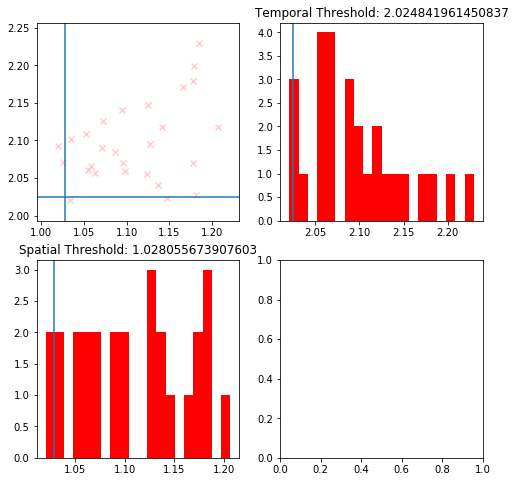

In [4]:
spatial_thresh, temporal_thresh = determine_thresholds((fov_height, fov_width, num_frames),
                                                       (block_height, block_width),
                                                       consec_failures, max_iters_main, 
                                                       max_iters_init, tol, 
                                                       d_sub, t_sub, 5, True)

## Decompose Each Block Into Spatial & Temporal Components

In [5]:
# Blockwise Parallel, Single Tiling
if not overlapping:    
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices = batch_decompose(fov_height, fov_width, num_frames,
                                    mov, block_height, block_width,
                                    max_components, consec_failures,
                                    max_iters_main, max_iters_init, tol,
                                    d_sub=d_sub, t_sub=t_sub)
    
 # Blockwise Parallel, 4x Overlapping Tiling
else:   
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices,\
    block_weights = overlapping_batch_decompose(fov_height, fov_width, num_frames,
                                                mov, block_height, block_width,
                                                spatial_thresh, temporal_thresh,
                                                max_components, consec_failures,
                                                max_iters_main, max_iters_init, tol,
                                                d_sub=d_sub, t_sub=t_sub)

# Reconstruct Denoised Video

In [6]:
# Single Tiling (No need for reqweighting)
if not overlapping: 
    mov_denoised = np.asarray(batch_recompose(spatial_components,
                                              temporal_components,
                                              block_ranks,
                                              block_indices))
# Overlapping Tilings With Reweighting
else:  
    mov_denoised = np.asarray(overlapping_batch_recompose(fov_height, fov_width, num_frames,
                                                          block_height, block_width,
                                                          spatial_components,
                                                          temporal_components,
                                                          block_ranks,
                                                          block_indices,
                                                          block_weights)) 

# Produce Diagnostics

### Single Tiling Pixel-Wise Ranks

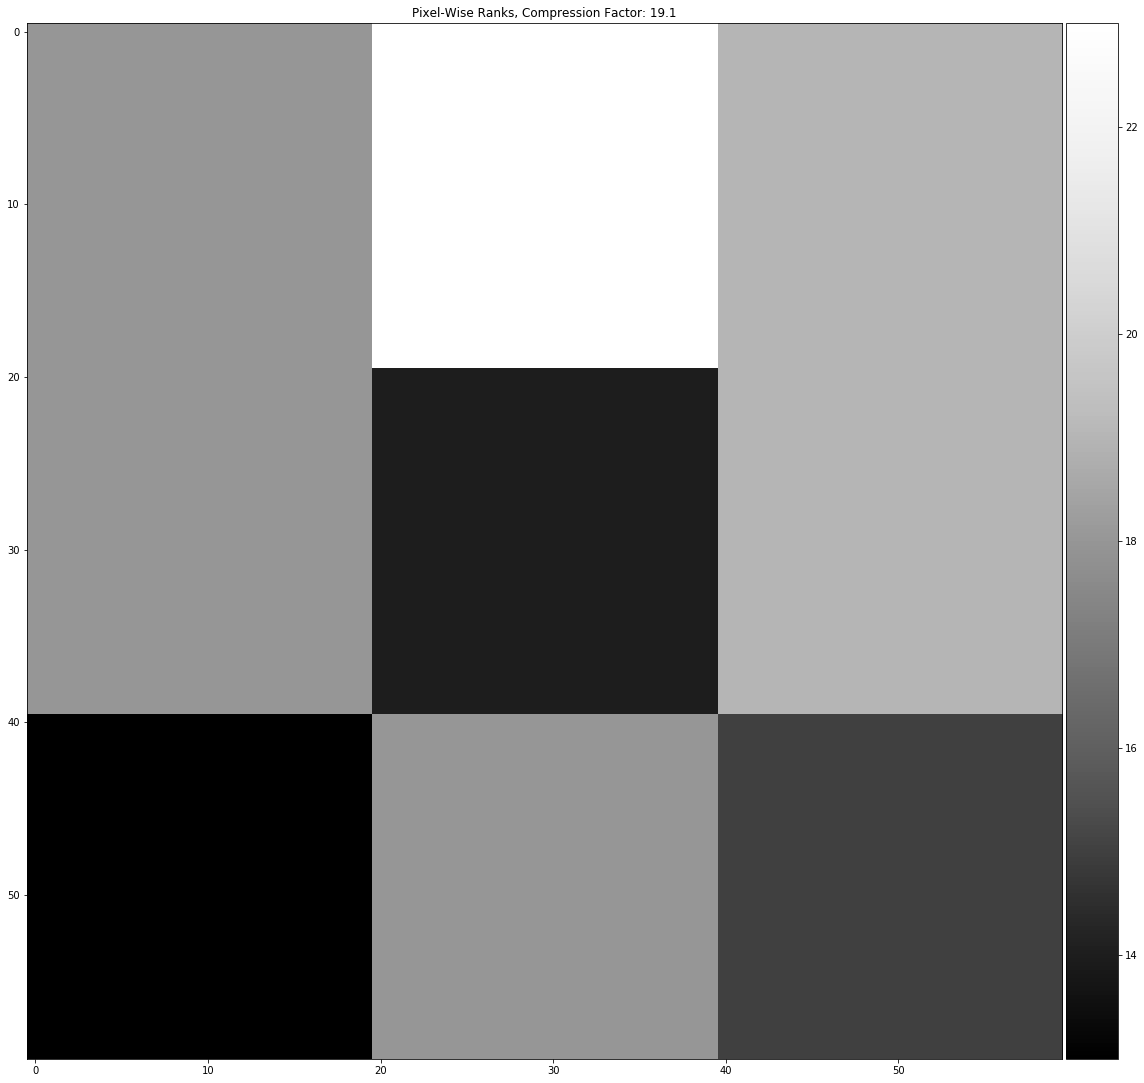

In [7]:
if overlapping:
    pixelwise_ranks(block_ranks['no_skew']['full'], fov_height, fov_width, num_frames, block_height, block_width)
else:
    pixelwise_ranks(block_ranks, fov_height, fov_width, num_frames, block_height, block_width)

### Correlation Images

In [8]:
from funimag.plots import util_plot

Local correlation:  range [2.1e-01 9.3e-01]
Local correlation:  range [6.1e-01 1.0e+00]
Local correlation:  range [-2.4e-01 2.3e-01]


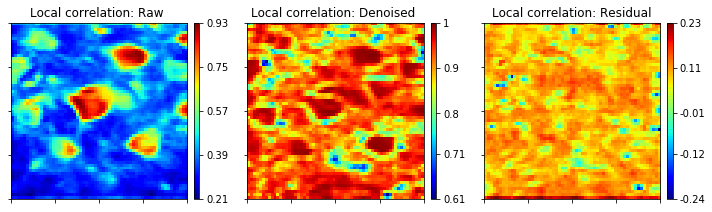

In [9]:
util_plot.comparison_plot([mov, mov_denoised + np.random.randn(np.prod(mov.shape)).reshape(mov.shape)*.01],
                plot_orientation="vertical")

## Render Videos & Residual

In [ ]:
play_cv2(np.vstack([mov, mov_denoised, mov-mov_denoised]), magnification=2)

# Save Results

In [10]:
U, V = overlapping_component_reformat(fov_height, fov_width, num_frames,
                                      block_height, block_width,
                                      spatial_components,
                                      temporal_components,
                                      block_ranks,
                                      block_indices,
                                      block_weights)

In [11]:
np.savez(os.path.join(ext, "demo_results.npz"), U, V,block_ranks,block_height,block_width)